# OpenAI Gym

https://github.com/openai/gym

In [1]:
import gym
import numpy as np 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## CartPole problem

Full description: https://github.com/openai/gym/wiki/CartPole-v0

Some aspects have been copied below.

In [3]:
env = gym.make('CartPole-v0')

In [4]:
# Go to start state
env.reset()

array([ 0.04096567, -0.03126615,  0.01125584,  0.00174365])

The state array has four variables corresponding to - 
#### Observation - Type: Box(4)

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

#### Actions - Type: Discrete(2)

Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right


In [5]:
env.observation_space

Box(4,)

In [6]:
env.action_space

Discrete(2)

In [7]:
# Generate a random action
env.action_space.sample()

0

In [8]:
# Make an action!
action = env.action_space.sample() # or 0, 1
observation, reward, done, info = env.step(action)
print('Observation:', observation)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)

Observation: [ 0.04034035  0.16369258  0.01129071 -0.28736677]
Reward: 1.0
Done: False
Info: {}


In [9]:
# Keep moving the pole until it falls over
# The goal is to keep it up for as many steps as possible!
env.reset()
counter = 0
done = False
while not done:
    observation, reward, done, _ = env.step(env.action_space.sample())
    counter += 1
print('It took {} steps to fall down!'.format(counter))

It took 12 steps to fall down!


### Linear model

In [10]:
def model(state, w):
    return state.dot(w)

def action_from_model(state, w):
    m = model(state,w)
    if m < 0:
        return 0
    else:
        return 1

In [11]:
def play_episode(env, w):
    observation = env.reset()
    t = 0
    done = False
    while not done and counter < 1e6: # set a maximum in case
        action = action_from_model(observation, w)
        observation, reward, done, _ = env.step(action)
        t += 1
    return t

In [12]:
def play_many_episodes(env, w, epochs):
    avg_steps = 0
    for i in range(epochs):
        steps = play_episode(env, w)
        avg_steps = (avg_steps * i + steps) / (i+1)
    return avg_steps

In [13]:
env = gym.make('CartPole-v0')

best_weights = None
best_avg_steps = 0
steps_list = []
for i in range(100):
    # random search parameters
    w = np.random.random(4)*2 - 1 # values -1,1 centred on 0
    # test each w 100 times
    avg_steps = play_many_episodes(env, w, 100)
    steps_list.append(avg_steps)
    
    if avg_steps > best_avg_steps:
        best_avg_steps = avg_steps
        best_weights = w

In [14]:
print(best_avg_steps)

200.0


In [15]:
play_many_episodes(env, best_weights, 100)

200.0

Note that there is a hard coded maximum of 200 steps allowed! This triggers the done flag.

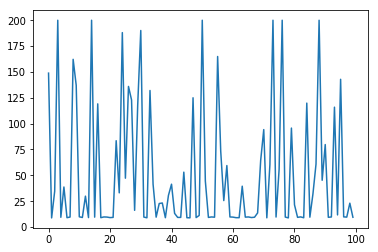

In [16]:
plt.plot(steps_list)

## Saving a video of the agent

In [17]:
from gym import wrappers

env_mon = wrappers.Monitor(env, 
                       'my_folder', # directory to save video in
                       force=True # clear the past files in directory
                      )
# print(play_episode(env_mon, best_weights))
print(play_episode(env_mon, w))

10
